In [2]:
%matplotlib inline

# load modules 
import warnings
from datetime import datetime
#from text_unidecode import unidecode
from collections import deque
import os
import multiprocessing
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from gensim.models import Word2Vec
from node2vec import Node2Vec
import altair as alt
import pyreadr
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

connection = pg.connect(host = 'postgis1', database = 'sdad', 
                        user = 'sz3wr', 
                        password = 'sz3wrsz3wr') 

edgelist_data = '''SELECT slug1, slug2, weight FROM gh_2007_2020.sna_repos_subnet_edges'''
#nodelist_data = '''select * from gh.sna_ctr_sectors '''

# convert to a dataframe, show how many missing we have (none)
edgelist_data = pd.read_sql_query(edgelist_data, con=connection)
#nodelist_data = pd.read_sql_query(nodelist_data, con=connection)
    
graph = nx.from_pandas_edgelist(edgelist_data, source='slug1', target='slug2', edge_attr='weight')
print("Node count:", graph.number_of_nodes(), "- Edge count:", graph.number_of_edges())



Node count: 416 - Edge count: 5237


to do: debug nodelist

In [4]:
nodelist_data = pd.read_csv('/project/class/bii_sdad_dspg/uva_2021/dspg21oss/descriptions_classified.csv')
#nodelist_data=nodelist_data.rename(columns={'slug':'source'})
nodelist_data.head()

,slug,description,language,commits,prog_go,prog_ruby,prog_cpp,prog_csharp,prog_clang,prog_objc,...,sys_emulapi,sys_grouping,sys_other,system_all,topics_ai,topics_dataviz,app_cryptocurrency,app_blockchain_all,app_business_all,app_database_all
0,otus-kuber-2019-12/OLEGIM_platform,olegim platform repository,C#,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,alex/line-counter,"like `wc -l`, but in rust and maybe faster",Rust,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,arlm/exercism,http://exercism.io/ practice,C#,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ksundong/TIL,today i learned // 그날 그날 공부한 내용을 정리하여 관리한다.,NaN,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ianmartinez/AsciiStudio,a cross-platform program that converts both st...,Java,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
edgelist_data.columns=['source', 'target', 'weight']
edgelist_data.head()
#edgelist_data.to_csv('/project/class/bii_sdad_dspg/uva_2021/dspg21oss/edgelist.csv')

,source,target,weight
0,elixir-lang/elixir,phoenixframework/phoenix,100
1,Homebrew/brew,Homebrew/homebrew-cask,66
2,angular/angular,angular/angular-cli,41
3,angular/angular,angular/components,27
4,Seldaek/monolog,symfony/symfony,26


In [3]:
#node2vec
cores_available = multiprocessing.cpu_count() - 1

# train the graph with node2vec 
print("Started at:", datetime.now())
# node2vec
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=cores_available)
# extract model
model = node2vec.fit(window=10, min_count=1)
print("Finished at:", datetime.now())


model.save("node2vec_sz.model")

# Running large graphs 
# https://github.com/eliorc/node2vec
# https://github.com/eliorc/node2vec/blob/master/example.py
#node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4, temp_folder="/mnt/tmp_data")

Started at: 2021-07-30 08:47:09.129854


Computing transition probabilities:   0%|          | 0/416 [00:00<?, ?it/s]

Finished at: 2021-07-30 08:47:35.760274


In [6]:
#node attributes

# import the node2vec model 
#os.chdir('/git/dspg21oss/data/dspg21oss/')
model = Word2Vec.load("node2vec_sz.model")

# run centrality measures 
deg_cent = nx.degree_centrality(graph) #degree centrality
btw_cent = nx.betweenness_centrality(graph, normalized = True, endpoints = False) #betweeness centrality
page_rank = nx.pagerank(graph, alpha = 0.8) #page rank

deg_cent_df = pd.DataFrame(deg_cent.items(), columns=['slug', 'deg_cent'])
btw_cent_df = pd.DataFrame(btw_cent.items(), columns=['slug', 'btw_cent'])
page_rank_df = pd.DataFrame(page_rank.items(), columns=['slug', 'page_rank'])


deg_cent_df = btw_cent_df.join(deg_cent_df.set_index('slug'), on='slug', how='left')
cent_measures = page_rank_df.join(deg_cent_df.set_index('slug'), on='slug', how='left')
cent_measures


,slug,page_rank,btw_cent,deg_cent
0,elixir-lang/elixir,0.006308,0.002009,0.069880
1,phoenixframework/phoenix,0.007031,0.008009,0.077108
2,Homebrew/brew,0.008249,0.020599,0.132530
3,Homebrew/homebrew-cask,0.025073,0.186809,0.356627
4,angular/angular,0.006497,0.003586,0.089157
...,...,...,...,...
411,typicode/json-server,0.000521,0.000000,0.002410
412,domnikl/DesignPatternsPHP,0.000545,0.000000,0.002410
413,bilibili/flv.js,0.000766,0.000000,0.002410
414,shadowsocks/shadowsocks-windows,0.001039,0.000000,0.002410


In [5]:
#graph attributes
density=nx.density(graph) #density, need nodelist to work first

transit=nx.transitivity(graph) #transitivity: .6027
#transit

cluster=nx.clustering(graph) # clustering, local density per node
#cluster

avg_cluster=nx.average_clustering(graph)
#avg_cluster

print("transitivity:", transit, "\naverage cluster:", avg_cluster, "\ndensity", density)

transitivity: 0.6027611764180608 
average cluster: 0.4394072937055666 
density 0.060669601482854496


In [7]:
# join all of the node attributes together for data viz 
model = Word2Vec.load("node2vec_sz.model")

vocab = list(model.wv.index_to_key) #figure this out
model_x = model.wv[vocab]
model_tsne = TSNE(n_components=2)
model_tsne_x = model_tsne.fit_transform(model_x)
model_tsne_x
tsne_df = pd.DataFrame(model_tsne_x, index=vocab, columns=['x', 'y'])
tsne_df["slug"] = vocab
tsne_df = tsne_df.join(nodelist_data.set_index('slug'), on='slug', how='left')
tsne_df = cent_measures.join(tsne_df.set_index('slug'), on='slug', how='left')
tsne_df.to_csv('/project/class/bii_sdad_dspg/uva_2021/dspg21oss/tsne_df.csv')

In [16]:
list(tsne_df.columns)

['slug',
 'page_rank',
 'btw_cent',
 'deg_cent',
 'x',
 'y',
 'description',
 'language',
 'commits',
 'prog_go',
 'prog_ruby',
 'prog_cpp',
 'prog_csharp',
 'prog_clang',
 'prog_objc',
 'prog_objcpp',
 'prog_rust',
 'prog_perl',
 'prog_swift',
 'prog_haskell',
 'prog_groovy',
 'prog_clojure',
 'prog_ocaml',
 'prog_dotnet',
 'prog_vbdotnet',
 'prog_fsharp',
 'prog_fortran',
 'prog_commonlisp',
 'prog_coq',
 'prog_gen_all',
 'prog_python',
 'prog_scala',
 'prog_rlang',
 'prog_matlab',
 'prog_stata',
 'prog_sas',
 'prog_julia',
 'prog_stat_all',
 'prog_javascript',
 'prog_java',
 'prog_typescript',
 'prog_php',
 'prog_html',
 'prog_css',
 'prog_dart',
 'prog_kotlin',
 'prog_lua',
 'prog_coffeescript',
 'prog_dm',
 'prog_erlang',
 'prog_elixer',
 'prog_jsonnet',
 'prog_elm',
 'prog_webassembly',
 'prog_purescript',
 'prog_web_all',
 'sys_general',
 'sys_os',
 'sys_windows',
 'sys_linux',
 'sys_mac',
 'sys_modern',
 'sys_bsd',
 'sys_android',
 'sys_solaris',
 'sys_virtual',
 'sys_handheld'

## Louvain Community Detection Algorithm

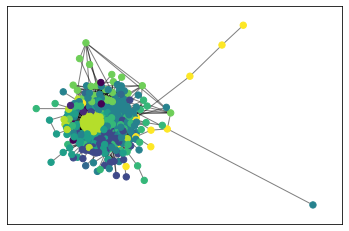

<Figure size 9216x6912 with 0 Axes>

In [27]:
#https://python-louvain.readthedocs.io/en/latest/

partition = community_louvain.best_partition(graph)

# draw the graph
pos = nx.kamada_kawai_layout(graph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(graph, pos, alpha=0.5)
plt.figure(figsize=(128, 96))
plt.show()

# to do: redo in gephi?
# https://medium.com/analytics-vidhya/implement-louvain-community-detection-algorithm-using-python-and-gephi-with-visualization-871250fb2f25

## Visualization

In [18]:
alt.Chart(tsne_df, title="Node Embedding by Programming Language").mark_circle(size=150).encode(
    x='x', y='y', color='language', size='commits', tooltip=['slug']).interactive().properties(
    width=700, height=500)

alt.Chart(...)

In [8]:
domain=['Python', 'Java', 'Javascript', 'C', 'PHP', 'Ruby']

alt.Chart(tsne_df, title="Node Embedding by Programming Language").mark_circle().encode(
    x='x', y='y', color=alt.Color('language', scale=alt.Scale(domain=domain)), size=alt.Size('deg_cent'), tooltip=['slug', 'language']).interactive().properties(
    width=700, height=500)

alt.Chart(...)

In [21]:
domain=['1', '0']
range=['red', 'blue']

alt.Chart(tsne_df, title="Node Embedding by Programming Language").mark_circle().encode(
    x='x', y='y', color=alt.Color('prog_python', scale=alt.Scale(domain=domain, range=range)), size=alt.Size('page_rank'), tooltip=['slug', 'language', 'description']).interactive().properties(
    width=700, height=500)

alt.Chart(...)

## old viz

In [ ]:
# all companies
alt.Chart(tsne_df, title="Node Embedding of OSS Collaboration Networks (by Company)").mark_circle(size=150).encode(
   x='x', y='y', 
    color='company_cleaned',#alt.Color('sector', scale=alt.Scale(domain=domain, range=range_)),
    size=alt.Size('page_rank'),
    tooltip=['login', 'sector', 'city_info', 'cc_viz', 'company_original', 'company_cleaned']
).interactive().properties(
    width=700,
    heig

In [9]:
# embeddings by sector code
domain = ['academic', 'business', 'non-profit', 'government']# , 'not classified', 'null/missing']
range_ = ['crimson', 'teal', 'darkorange', 'darkblue'] #, 'lightgrey', 'lightgrey']

alt.Chart(tsne_df,title="Node Embedding of OSS Collaboration Networks (by Sector)").mark_circle().encode(
   x='x', y='y', 
    color=alt.Color('sector', scale=alt.Scale(domain=domain, range=range_)),
    size=alt.Size('page_rank'),
    tooltip=['login', 'sector', 'city_info', 'cc_viz', 'company_original', 'company_cleaned']
).interactive().properties(
    width=700,
    height=500
)

NameError: name 'tsne_df' is not defined

In [ ]:
# top companies
domain = ['microsoft', 'google', 'red hat', 'ibm', 'facebook', 'intel', 'thoughtworks', 'alibaba', 'amazon', 'databricks']

alt.Chart(tsne_df, title="Node Embedding of OSS Collaboration Networks (Top Companies)").mark_circle().encode(
   x='x', y='y', 
    color=alt.Color('company_cleaned', scale=alt.Scale(domain=domain)),
    size=alt.Size('page_rank'),
    tooltip=['login', 'sector', 'city_info', 'cc_viz', 'company_original', 'company_cleaned']
).interactive().properties(
    width=700,
    height=500
)

In [ ]:
# country
alt.Chart(tsne_df,title="Node Embedding of OSS Collaboration Networks (by Country)").mark_circle(size=150).encode(
   x='x', y='y', 
    color='cc_viz',
    size=alt.Size('page_rank'),
    tooltip=['login', 'sector', 'city_info', 'cc_viz', 'company_original', 'company_cleaned']
).interactive().properties(
    width=700,
    height=500
)
